In [177]:
import numpy as np
import argparse
import time
import cv2
import os
import imutils
from matplotlib import pyplot as plt
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

In [178]:
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) != 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) != 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)

In [179]:
def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0/pixel_number
    his, bins = np.histogram(gray, np.arange(0,257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight

        mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
        #print mub, muf
        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = gray.copy()
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img


In [180]:
LABELS = open('./yolov4/coco.names').read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [181]:
net = cv2.dnn.readNetFromDarknet('./yolov4/water.cfg', './yolov4/water.weights')

In [182]:
image = cv2.imread('./data/depa/new/2.jpeg')
(H, W) = image.shape[:2]

ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.424474 seconds


In [183]:
boxes = []
confidences = []
classIDs = []

In [184]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [185]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,
	0.3)

In [186]:
idxs

array([[1]], dtype=int32)

medidor: 0.8715


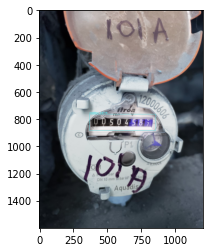

In [187]:
image_tmp = image.copy()
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image_tmp, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		print(text)
		cv2.putText(image_tmp, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
# show the output image

plt.imshow(image_tmp)

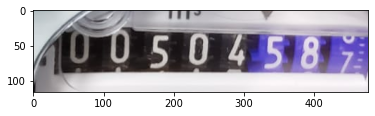

In [188]:
cla = 0
(x, y) = (boxes[cla][0], boxes[cla][1])
(w, h) = (boxes[cla][2], boxes[cla][3])

crop_img = image[y:y+h, x:x+w].copy()
plt.imshow(crop_img)

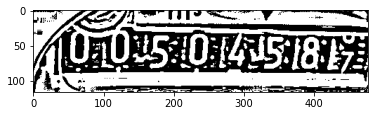

In [189]:
from scipy.ndimage import gaussian_filter

img = cv2.imread('testtest.pnh', 0)
new_flow = gaussian_filter(crop_img, sigma=1)
new_flow_gray = cv2.cvtColor(new_flow, cv2.COLOR_BGR2GRAY)
new_flow_tresh = cv2.adaptiveThreshold(new_flow_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,1)
plt.imshow(new_flow_tresh, cmap='gray')

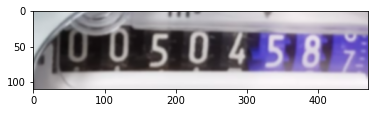

In [190]:
d = 3

#Operacion de Suavizado (Blur)
img_blur = cv2.GaussianBlur(crop_img, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
plt.imshow(img_blur)

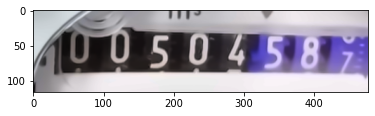

In [191]:
dst = cv2.fastNlMeansDenoisingColored(crop_img,None,10,10,7,21)
plt.imshow(dst)

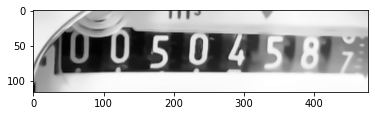

In [192]:
crop_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
plt.imshow(crop_gray, cmap='Greys_r')

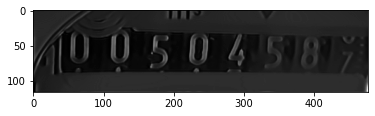

In [193]:
homo_filter = HomomorphicFilter(a = .65, b = 2.25)

img_filtered = homo_filter.filter(I=crop_gray, filter_params=[30,2])
plt.imshow(img_filtered, cmap='Greys_r')

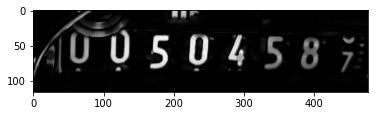

In [194]:
selem = disk(6)
phantom = img_filtered.copy()
phantom[340:350, 200:210] = 255
phantom[100:110, 200:210] = 0

w_tophat = white_tophat(crop_gray, selem)
plt.imshow(w_tophat, cmap='Greys_r')

<ipython-input-179-63f417fec1d8>:15: RuntimeWarning: invalid value encountered in true_divide
  muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)


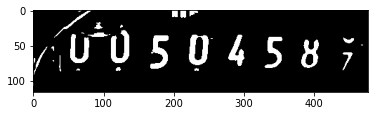

In [195]:
otsu_img = otsu(w_tophat)
plt.imshow(otsu_img, cmap='Greys_r')

In [196]:
# thresh = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,2))
# otsu_img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

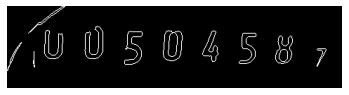

In [197]:
contours, hierarchy = cv2.findContours(otsu_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_dict = dict()
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.contourArea(cont)
    # print(h)
    if area > 0 and h > 12:
        contours_dict[(x, y, w, h)] = cont
    # if area > 0.7 * w * h:
    #     contours_dict[(x, y, w, h)] = cont
    # contours_dict[(x, y, w, h)] = cont

contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)

blank_background = np.zeros_like(otsu_img.copy())
img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=1)
# img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (100,100,100), thickness=cv2.FILLED)
plt.axis('off')
plt.imshow(img_contours, cmap='Greys_r')

In [198]:
def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1

def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes

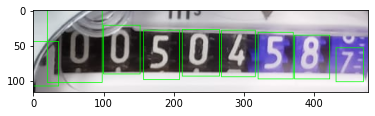

In [199]:
boxes = windows(contours_filtered)
for box in boxes:
    x, y, w, h = box
    img = cv2.rectangle(crop_img, (x-10, y-7), (x + w + 15, y + h +15), (0, 255, 0), 1)
plt.imshow(crop_img)

True

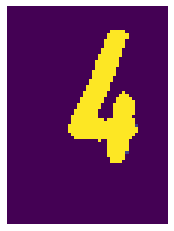

In [201]:
x, y, w, h = boxes[5]
plt.axis('off')
roi = otsu_img[y-8:y+h+20, x-20:x+w+10]
plt.imshow(roi)
cv2.imwrite('testtest.png', roi)